# Import libraries

In [0]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**List the devices available to tensorflow**

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5381542240454213764, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11297803469
 locality {
   bus_id: 1
 }
 incarnation: 12932021769274050543
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
!pip install --upgrade gensim
from gensim.models.word2vec import Word2VecKeyedVectors

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: numpy>=1.11.3 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: scipy>=0.18.1 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: six>=1.5.0 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: smart-open>=1.2.1 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: bz2file in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: boto>=2.32 in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: boto3 in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: idna<2.7,>=2.5 i

**Make the result reproducible by setting the seed of numpy and tensorflow**

In [4]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


# Load the cleaned data

**Authentication via google auth**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Upload a file from google cloud where file ids are stored as a json**

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

file_id_data= json.loads(uploaded['file_id.json'])

User uploaded file "file_id.json" with length 489 bytes


**Download files to the kernel**

In [0]:
downloaded1 = drive.CreateFile({'id':file_id_data["modified_train_file_id"]}) 
downloaded1.GetContentFile('modified_train_data.csv')  
downloaded2 = drive.CreateFile({'id':file_id_data["modified_test_file_id"]}) 
downloaded2.GetContentFile('modified_test_data.csv')
downloaded3 = drive.CreateFile({'id':file_id_data["word2vec_model"]}) 
downloaded3.GetContentFile('word2vec_model')  
downloaded4 = drive.CreateFile({'id':file_id_data["data"]}) 
downloaded4.GetContentFile('data.json')

**Load train and test data to notebook**

In [0]:
#3. Read file as panda dataframe
data = pd.read_csv('modified_train_data.csv') 
test_data = pd.read_csv('modified_test_data.csv')

**remove the csv files from kernel**

In [0]:
os.remove("modified_train_data.csv")
os.remove("modified_test_data.csv")

**Extract the size of Word2Vec model**

In [0]:
metadata= json.loads(open("data.json").read())
size = metadata['size']

**Load the saved Word2Vec model**

In [0]:
fname = "word2vec_model"
model = Word2VecKeyedVectors.load_word2vec_format(fname)

In [0]:
os.remove("word2vec_model")

# Inspect the distribution of #words in the sentences

**Distribution of #words in train data**

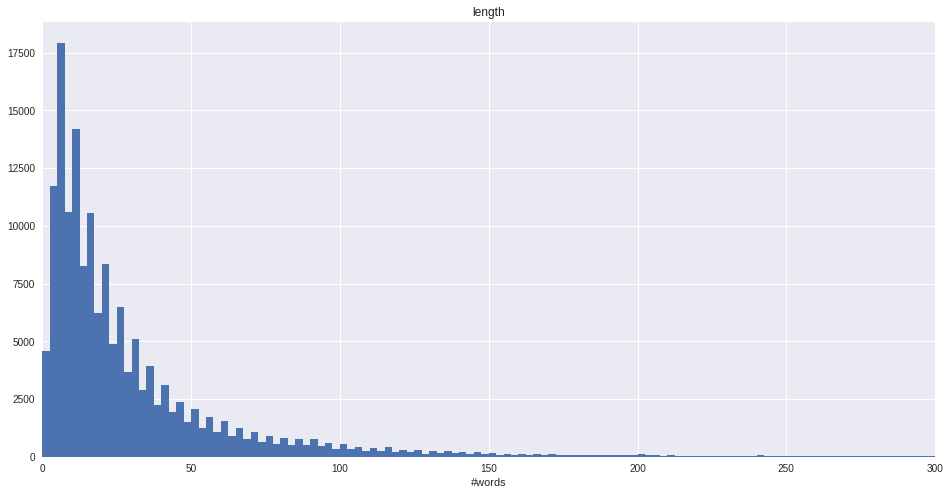

In [13]:
data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in test data**

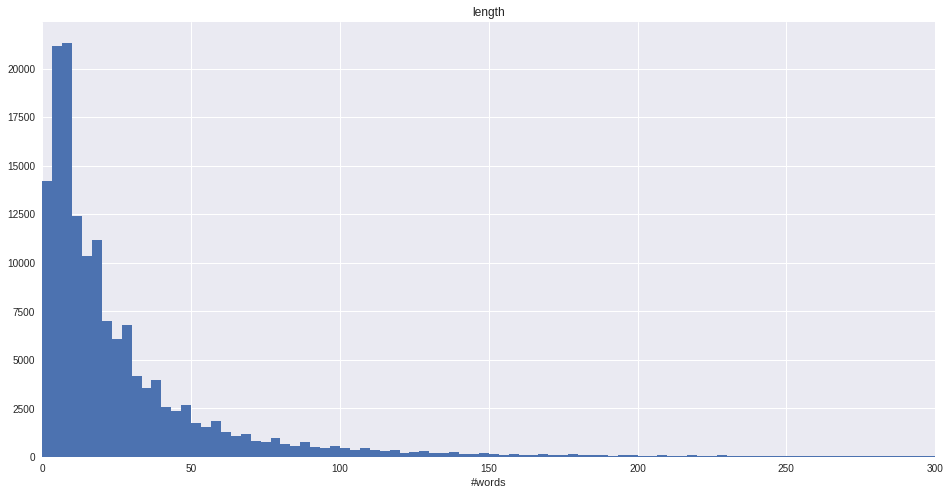

In [14]:
test_data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in all data**

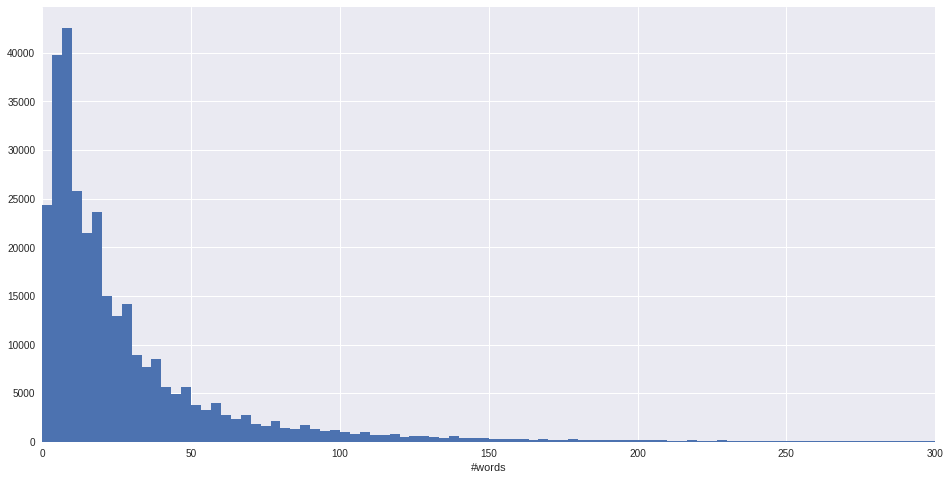

In [15]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=500, figsize=(16,8))
plt.xlim(0,300)
plt.xlabel("#words")
plt.show()
del(all_length)

# Train validation split

**Extract the train, validation, and test data in numpy arrays**

In [0]:
comments = data["comment_text"].as_matrix()
sentiments = data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].as_matrix()
seq_length = data['length'].as_matrix()

# randomly generate train and validation indices
train_indices = np.random.choice(len(seq_length), round(len(seq_length)*0.96), replace=False)
validation_indices = np.array(list(set(range(len(seq_length))) - set(train_indices)))

comments_train = comments[train_indices]
comments_validation = comments[validation_indices]
comments_test = test_data["comment_text"].as_matrix()

seq_length_train = seq_length[train_indices]
seq_length_validation = seq_length[validation_indices]
seq_length_test = test_data['length'].as_matrix()

sentiments_train = sentiments[train_indices]
sentiments_validation = sentiments[validation_indices]

test_id = test_data['id'].as_matrix()

In [17]:
print("shape of comments_train:",comments_train.shape)
print("shape of comments_validation:",comments_validation.shape)
print("shape of comments_test:",comments_test.shape)
print("shape of seq_length_train:",seq_length_train.shape)
print("shape of seq_length_validation:",seq_length_validation.shape)
print("shape of seq_length_test:",seq_length_test.shape)
print("shape of sentiments_train:",sentiments_train.shape)
print("shape of sentiments_test:",sentiments_validation.shape)
print("shape of test_id:",test_id.shape)

shape of comments_train: (153188,)
shape of comments_validation: (6383,)
shape of comments_test: (153164,)
shape of seq_length_train: (153188,)
shape of seq_length_validation: (6383,)
shape of seq_length_test: (153164,)
shape of sentiments_train: (153188, 6)
shape of sentiments_test: (6383, 6)
shape of test_id: (153164,)


In [0]:
del(train_indices, validation_indices, data, test_data, comments, sentiments, seq_length)

# Create Recurrent Neural Network (LSTM cell)

**A function to generate fixed length sequence**

In [0]:
def sequence_generator(comments, max_length, size):
    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**Parameters of sequence data**

In [0]:
max_length = n_steps =250 
size = n_inputs = size
n_outputs = 6

**Function to generate batch data**

In [0]:
def generate_train_batch(indices, comments, seq_length, sentiments, max_length, size):
    
    comments_batch = comments[indices]
    seq_length_batch = seq_length[indices]
    sentiments_batch = sentiments[indices]
    
    sequences_batch = sequence_generator(comments_batch, max_length, size)
    
    return sequences_batch, seq_length_batch, sentiments_batch

**Placeholders**

In [0]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
labels = tf.placeholder(tf.float32, [None, n_outputs])
length = tf.placeholder(tf.int32, [None])
keep_prob = tf.placeholder(tf.float32)

## Creat RNN layer

**Create a multilayered lstm network**

In [0]:
n_layers = 2
n_neurons = 128

In [0]:
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
lstm_cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
                    for cell in lstm_cells]
cells_across_gpu = [tf.contrib.rnn.DeviceWrapper("/device:GPU:0", cell) for cell in lstm_cells_drop]

multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

**Extract the short term output of the last lstm cell**

In [25]:
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32, sequence_length=length)
top_layer_h_state = states[-1][1]
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 128) dtype=float32>

## Create fully connected layers

**Functions to create weights and biases**

In [0]:
def create_weights(shape):
    '''a function to create weight tensor'''
    with tf.device("/device:CPU:0"):
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    return W

def create_biases(size):
    '''a function to create bias tensor'''
    with tf.device("/device:CPU:0"):
        b = tf.Variable(tf.constant(0.05, shape=[size]))
    return b

**Function to create fully connected layer**

In [0]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=False,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    with tf.device("/device:GPU:0"):
      # matrix multiplication between input and weight matrix
      layer = tf.matmul(input, weights)

      # add the bias to the convolutional layer
      layer += biases

      # add relu activation if wanted
      if use_relu:
          layer = tf.nn.relu(layer)

      # if dropout is wanted add dropout
      if dropout:        
          layer = tf.nn.dropout(layer, keep_prob)

    # return layer
    return layer

**Create fully connected layer**

In [0]:
fc_layer_size1 = 64
# fc_layer_size2 = 64

In [29]:
layer_fc1 = create_fc_layer(input=top_layer_h_state,
                            num_inputs=top_layer_h_state.get_shape()[1].value,
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout =True,
                            keep_prob = keep_prob)
layer_fc1

<tf.Tensor 'dropout/mul:0' shape=(?, 64) dtype=float32>

In [0]:
# layer_fc2 = create_fc_layer(input=layer_fc1,
#                             num_inputs=fc_layer_size1,
#                             num_outputs=fc_layer_size2,
#                             use_relu=True,
#                             dropout =True,
#                             keep_prob = keep_prob)
# layer_fc2

**Create output layer**

In [31]:
output = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=n_outputs,
                            use_relu=False,
                            dropout =False)
output

<tf.Tensor 'add_1:0' shape=(?, 6) dtype=float32>

**Sigmoid of the output**

In [32]:
with tf.device("/device:GPU:0"):
    logits = tf.nn.sigmoid(output)
logits

<tf.Tensor 'Sigmoid:0' shape=(?, 6) dtype=float32>

## Create optimization operation

**Loss operation**

In [0]:
with tf.device("/device:GPU:0"):
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=output)

**ROC AUC calculation operations**

In [0]:
roc = tf.metrics.auc(labels=labels, predictions=logits)

**Train step**

In [0]:
# learning rate of optimizer
learning_rate = (1e-2)*1.5
with tf.device("/device:GPU:0"):
  # train step
  train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Train the model

In [0]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []
valid_roc = []

# batch size
batch_size = 200
# max iteration
max_iter = 10000

**Train model for few hours and save the best model along the way**

In [37]:
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_accuracy = 0
best_roc = -10
best_iteration = None

iteration = 0

# number of hours for training
train_hours = 4

# feed dictionary for validation
feed_dict_validation =  {X:sequence_generator(comments_validation, max_length, size),
                        labels:sentiments_validation,
                        length:seq_length_validation,
                        keep_prob: 1.0}

t1 = time.time()

# create a graph session and optimize under it
with tf.Session() as sess:
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # while minutes have not elapsed 
    while (time.time()-t1) < train_hours*60*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randomly choosing the indices of the batch 
        rand_index = np.random.choice(sentiments_train.shape[0], size=batch_size)

        # extract the batch data
        sequences_batch, seq_length_batch, sentiments_batch = \
        generate_train_batch(rand_index, comments_train, seq_length_train, sentiments_train,
                             max_length, size)
        
        # feed dictionary for batch
        feed_dict_batch =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 0.75}
        # feed dictionary for train
        feed_dict_train =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 1.0}        
        
        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)

        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        # calculate roc score
        temp_roc_score = sess.run(roc, feed_dict=feed_dict_validation)[1]
        valid_roc.append(temp_roc_score)
        
        # if valid loss is better than best recorded so far then
        # update the parameters of the best model and save the model
        if temp_roc_score > best_roc:
            best_roc = temp_roc_score
            best_iteration = iteration          
            saver.save(sess, './my-model', global_step = best_iteration)

        # print metric info
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss,
              "| Roc Score:", temp_roc_score,
              "| Time elapsed:",str(datetime.timedelta(seconds=time.time()-t1)))
        
        # increment iteration
        iteration = iteration+1

iterations: 0 | train_loss: 0.48448765 | validation_loss: 0.49085554 | Roc Score: 0.5986242 | Time elapsed: 0:00:04.408242
iterations: 1 | train_loss: 0.17204307 | validation_loss: 0.19217731 | Roc Score: 0.5201364 | Time elapsed: 0:00:08.232821
iterations: 2 | train_loss: 0.1554768 | validation_loss: 0.18152359 | Roc Score: 0.4992172 | Time elapsed: 0:00:12.010513
iterations: 3 | train_loss: 0.17880297 | validation_loss: 0.22378254 | Roc Score: 0.49971405 | Time elapsed: 0:00:15.771984
iterations: 4 | train_loss: 0.19757749 | validation_loss: 0.22850215 | Roc Score: 0.5009507 | Time elapsed: 0:00:19.594676
iterations: 5 | train_loss: 0.18305013 | validation_loss: 0.20804897 | Roc Score: 0.5183123 | Time elapsed: 0:00:23.390193
iterations: 6 | train_loss: 0.19798213 | validation_loss: 0.1765757 | Roc Score: 0.538178 | Time elapsed: 0:00:27.202319
iterations: 7 | train_loss: 0.12611595 | validation_loss: 0.16378632 | Roc Score: 0.5622341 | Time elapsed: 0:00:31.021518
iterations: 8 | tr

iterations: 78 | train_loss: 0.13843922 | validation_loss: 0.13297033 | Roc Score: 0.7225969 | Time elapsed: 0:05:07.268659
iterations: 79 | train_loss: 0.1415975 | validation_loss: 0.13261409 | Roc Score: 0.7233021 | Time elapsed: 0:05:11.147561
iterations: 80 | train_loss: 0.15981929 | validation_loss: 0.1312563 | Roc Score: 0.724246 | Time elapsed: 0:05:15.023912
iterations: 81 | train_loss: 0.1628509 | validation_loss: 0.13271339 | Roc Score: 0.7249798 | Time elapsed: 0:05:18.931683
iterations: 82 | train_loss: 0.13694763 | validation_loss: 0.13318163 | Roc Score: 0.72572774 | Time elapsed: 0:05:22.848541
iterations: 83 | train_loss: 0.15822934 | validation_loss: 0.1315996 | Roc Score: 0.72656363 | Time elapsed: 0:05:26.730133
iterations: 84 | train_loss: 0.14874706 | validation_loss: 0.12953171 | Roc Score: 0.7275533 | Time elapsed: 0:05:30.614053
iterations: 85 | train_loss: 0.17038263 | validation_loss: 0.12901819 | Roc Score: 0.7285386 | Time elapsed: 0:05:34.504445
iterations:

iterations: 156 | train_loss: 0.07327115 | validation_loss: 0.07864583 | Roc Score: 0.82290006 | Time elapsed: 0:10:10.958937
iterations: 157 | train_loss: 0.12200872 | validation_loss: 0.0875886 | Roc Score: 0.8238394 | Time elapsed: 0:10:14.911631
iterations: 158 | train_loss: 0.073459156 | validation_loss: 0.088948935 | Roc Score: 0.8247491 | Time elapsed: 0:10:18.766093
iterations: 159 | train_loss: 0.084646404 | validation_loss: 0.07626504 | Roc Score: 0.8259061 | Time elapsed: 0:10:22.624827
iterations: 160 | train_loss: 0.08932635 | validation_loss: 0.08348442 | Roc Score: 0.82690406 | Time elapsed: 0:10:26.466913
iterations: 161 | train_loss: 0.1183234 | validation_loss: 0.0831905 | Roc Score: 0.8279188 | Time elapsed: 0:10:30.364733
iterations: 162 | train_loss: 0.09116668 | validation_loss: 0.076407254 | Roc Score: 0.8290307 | Time elapsed: 0:10:34.290257
iterations: 163 | train_loss: 0.085881606 | validation_loss: 0.081203155 | Roc Score: 0.8300102 | Time elapsed: 0:10:38.15

iterations: 234 | train_loss: 0.034158397 | validation_loss: 0.06976571 | Roc Score: 0.87880886 | Time elapsed: 0:15:14.622265
iterations: 235 | train_loss: 0.038663823 | validation_loss: 0.07490828 | Roc Score: 0.87912345 | Time elapsed: 0:15:18.504944
iterations: 236 | train_loss: 0.06007 | validation_loss: 0.077595174 | Roc Score: 0.8793878 | Time elapsed: 0:15:22.410322
iterations: 237 | train_loss: 0.10981263 | validation_loss: 0.07207457 | Roc Score: 0.87974864 | Time elapsed: 0:15:26.306890
iterations: 238 | train_loss: 0.086495325 | validation_loss: 0.069560684 | Roc Score: 0.8801947 | Time elapsed: 0:15:30.195223
iterations: 239 | train_loss: 0.06758283 | validation_loss: 0.079263724 | Roc Score: 0.88057303 | Time elapsed: 0:15:34.046168
iterations: 240 | train_loss: 0.08041761 | validation_loss: 0.0895905 | Roc Score: 0.88090116 | Time elapsed: 0:15:37.921574
iterations: 241 | train_loss: 0.080327876 | validation_loss: 0.081620164 | Roc Score: 0.8813004 | Time elapsed: 0:15:4

iterations: 312 | train_loss: 0.069977954 | validation_loss: 0.064315386 | Roc Score: 0.9043182 | Time elapsed: 0:20:18.633641
iterations: 313 | train_loss: 0.040561732 | validation_loss: 0.06537558 | Roc Score: 0.9045368 | Time elapsed: 0:20:22.509808
iterations: 314 | train_loss: 0.053300478 | validation_loss: 0.068239294 | Roc Score: 0.904706 | Time elapsed: 0:20:26.352773
iterations: 315 | train_loss: 0.07806104 | validation_loss: 0.07085156 | Roc Score: 0.904843 | Time elapsed: 0:20:30.260885
iterations: 316 | train_loss: 0.05956005 | validation_loss: 0.07087634 | Roc Score: 0.9049797 | Time elapsed: 0:20:34.174090
iterations: 317 | train_loss: 0.08777528 | validation_loss: 0.06605154 | Roc Score: 0.90518785 | Time elapsed: 0:20:38.130869
iterations: 318 | train_loss: 0.06754944 | validation_loss: 0.065066114 | Roc Score: 0.905422 | Time elapsed: 0:20:42.163453
iterations: 319 | train_loss: 0.060412634 | validation_loss: 0.0673648 | Roc Score: 0.90564907 | Time elapsed: 0:20:46.11

iterations: 390 | train_loss: 0.06463336 | validation_loss: 0.06245971 | Roc Score: 0.9192935 | Time elapsed: 0:25:24.052620
iterations: 391 | train_loss: 0.05677504 | validation_loss: 0.06254329 | Roc Score: 0.9194458 | Time elapsed: 0:25:27.920749
iterations: 392 | train_loss: 0.065096356 | validation_loss: 0.06381008 | Roc Score: 0.91959715 | Time elapsed: 0:25:31.793869
iterations: 393 | train_loss: 0.058442783 | validation_loss: 0.06434444 | Roc Score: 0.91974413 | Time elapsed: 0:25:35.743225
iterations: 394 | train_loss: 0.031687375 | validation_loss: 0.064067684 | Roc Score: 0.919879 | Time elapsed: 0:25:39.631775
iterations: 395 | train_loss: 0.05874587 | validation_loss: 0.065500155 | Roc Score: 0.91998416 | Time elapsed: 0:25:43.480584
iterations: 396 | train_loss: 0.050161395 | validation_loss: 0.066981964 | Roc Score: 0.92006904 | Time elapsed: 0:25:47.385251
iterations: 397 | train_loss: 0.057954688 | validation_loss: 0.06477784 | Roc Score: 0.92018205 | Time elapsed: 0:2

iterations: 468 | train_loss: 0.043502286 | validation_loss: 0.06390579 | Roc Score: 0.9288763 | Time elapsed: 0:30:27.900109
iterations: 469 | train_loss: 0.051862873 | validation_loss: 0.06353869 | Roc Score: 0.92895603 | Time elapsed: 0:30:31.813968
iterations: 470 | train_loss: 0.102879845 | validation_loss: 0.06094921 | Roc Score: 0.9290622 | Time elapsed: 0:30:35.726240
iterations: 471 | train_loss: 0.05869355 | validation_loss: 0.06255513 | Roc Score: 0.92916787 | Time elapsed: 0:30:39.638893
iterations: 472 | train_loss: 0.09040692 | validation_loss: 0.06416606 | Roc Score: 0.9292696 | Time elapsed: 0:30:43.606057
iterations: 473 | train_loss: 0.054755427 | validation_loss: 0.061565097 | Roc Score: 0.9293762 | Time elapsed: 0:30:47.464413
iterations: 474 | train_loss: 0.04609369 | validation_loss: 0.059552003 | Roc Score: 0.9294803 | Time elapsed: 0:30:51.344439
iterations: 475 | train_loss: 0.059608992 | validation_loss: 0.06282205 | Roc Score: 0.9295574 | Time elapsed: 0:30:5

iterations: 546 | train_loss: 0.04265604 | validation_loss: 0.057993893 | Roc Score: 0.93569416 | Time elapsed: 0:35:31.666107
iterations: 547 | train_loss: 0.05208165 | validation_loss: 0.058019307 | Roc Score: 0.9357735 | Time elapsed: 0:35:35.550176
iterations: 548 | train_loss: 0.051308274 | validation_loss: 0.057644527 | Roc Score: 0.9358533 | Time elapsed: 0:35:39.451775
iterations: 549 | train_loss: 0.06948721 | validation_loss: 0.05728414 | Roc Score: 0.93593353 | Time elapsed: 0:35:43.359881
iterations: 550 | train_loss: 0.07129767 | validation_loss: 0.057987154 | Roc Score: 0.936015 | Time elapsed: 0:35:47.259097
iterations: 551 | train_loss: 0.053227793 | validation_loss: 0.058275204 | Roc Score: 0.93609524 | Time elapsed: 0:35:51.140155
iterations: 552 | train_loss: 0.050632246 | validation_loss: 0.05746091 | Roc Score: 0.9361719 | Time elapsed: 0:35:55.058985
iterations: 553 | train_loss: 0.052856207 | validation_loss: 0.057088476 | Roc Score: 0.9362452 | Time elapsed: 0:3

iterations: 624 | train_loss: 0.047714937 | validation_loss: 0.06335404 | Roc Score: 0.940477 | Time elapsed: 0:40:35.265627
iterations: 625 | train_loss: 0.068860486 | validation_loss: 0.061423365 | Roc Score: 0.94053304 | Time elapsed: 0:40:39.204471
iterations: 626 | train_loss: 0.04514635 | validation_loss: 0.0589604 | Roc Score: 0.9405932 | Time elapsed: 0:40:43.092058
iterations: 627 | train_loss: 0.06421456 | validation_loss: 0.057422675 | Roc Score: 0.9406435 | Time elapsed: 0:40:47.026320
iterations: 628 | train_loss: 0.049639948 | validation_loss: 0.058581945 | Roc Score: 0.94068706 | Time elapsed: 0:40:50.916940
iterations: 629 | train_loss: 0.04988136 | validation_loss: 0.059113357 | Roc Score: 0.9407279 | Time elapsed: 0:40:54.831556
iterations: 630 | train_loss: 0.048137017 | validation_loss: 0.059885543 | Roc Score: 0.9407657 | Time elapsed: 0:40:58.716336
iterations: 631 | train_loss: 0.06759863 | validation_loss: 0.06020817 | Roc Score: 0.9408018 | Time elapsed: 0:41:0

iterations: 702 | train_loss: 0.035342667 | validation_loss: 0.05818583 | Roc Score: 0.9441428 | Time elapsed: 0:45:39.766944
iterations: 703 | train_loss: 0.05389514 | validation_loss: 0.056782458 | Roc Score: 0.9441751 | Time elapsed: 0:45:43.669576
iterations: 704 | train_loss: 0.049518555 | validation_loss: 0.056467794 | Roc Score: 0.94421625 | Time elapsed: 0:45:47.533119
iterations: 705 | train_loss: 0.055657916 | validation_loss: 0.058833268 | Roc Score: 0.94426143 | Time elapsed: 0:45:51.430594
iterations: 706 | train_loss: 0.044505198 | validation_loss: 0.060007483 | Roc Score: 0.9443051 | Time elapsed: 0:45:55.332113
iterations: 707 | train_loss: 0.06388888 | validation_loss: 0.05937497 | Roc Score: 0.9443483 | Time elapsed: 0:45:59.288106
iterations: 708 | train_loss: 0.049584206 | validation_loss: 0.057213366 | Roc Score: 0.9443885 | Time elapsed: 0:46:03.223013
iterations: 709 | train_loss: 0.057908434 | validation_loss: 0.05681961 | Roc Score: 0.9444216 | Time elapsed: 0:

iterations: 780 | train_loss: 0.04067217 | validation_loss: 0.05693746 | Roc Score: 0.9468955 | Time elapsed: 0:50:43.954036
iterations: 781 | train_loss: 0.04411702 | validation_loss: 0.057830244 | Roc Score: 0.94691765 | Time elapsed: 0:50:47.826759
iterations: 782 | train_loss: 0.056605306 | validation_loss: 0.057637937 | Roc Score: 0.9469411 | Time elapsed: 0:50:51.713747
iterations: 783 | train_loss: 0.039589956 | validation_loss: 0.057301763 | Roc Score: 0.9469648 | Time elapsed: 0:50:55.681135
iterations: 784 | train_loss: 0.055619005 | validation_loss: 0.055912163 | Roc Score: 0.9469982 | Time elapsed: 0:50:59.537748
iterations: 785 | train_loss: 0.07440786 | validation_loss: 0.05518546 | Roc Score: 0.94703746 | Time elapsed: 0:51:03.399940
iterations: 786 | train_loss: 0.057231154 | validation_loss: 0.055364322 | Roc Score: 0.94707716 | Time elapsed: 0:51:07.315741
iterations: 787 | train_loss: 0.06400444 | validation_loss: 0.05637066 | Roc Score: 0.9471159 | Time elapsed: 0:5

iterations: 858 | train_loss: 0.05929772 | validation_loss: 0.05437618 | Roc Score: 0.9495496 | Time elapsed: 0:55:47.231506
iterations: 859 | train_loss: 0.059785005 | validation_loss: 0.054763157 | Roc Score: 0.94958246 | Time elapsed: 0:55:51.140686
iterations: 860 | train_loss: 0.038288005 | validation_loss: 0.055880766 | Roc Score: 0.9496143 | Time elapsed: 0:55:55.029372
iterations: 861 | train_loss: 0.05967219 | validation_loss: 0.057087902 | Roc Score: 0.9496443 | Time elapsed: 0:55:58.925653
iterations: 862 | train_loss: 0.04162969 | validation_loss: 0.058284637 | Roc Score: 0.94967234 | Time elapsed: 0:56:02.846940
iterations: 863 | train_loss: 0.060298886 | validation_loss: 0.058186404 | Roc Score: 0.94970196 | Time elapsed: 0:56:06.760684
iterations: 864 | train_loss: 0.047984388 | validation_loss: 0.05791281 | Roc Score: 0.9497307 | Time elapsed: 0:56:10.645621
iterations: 865 | train_loss: 0.049598653 | validation_loss: 0.057068583 | Roc Score: 0.94975984 | Time elapsed: 

iterations: 936 | train_loss: 0.055003878 | validation_loss: 0.053714138 | Roc Score: 0.9517756 | Time elapsed: 1:00:51.641355
iterations: 937 | train_loss: 0.04650346 | validation_loss: 0.053375244 | Roc Score: 0.9518007 | Time elapsed: 1:00:55.539664
iterations: 938 | train_loss: 0.07234277 | validation_loss: 0.053575575 | Roc Score: 0.9518298 | Time elapsed: 1:00:59.425991
iterations: 939 | train_loss: 0.056864522 | validation_loss: 0.053643227 | Roc Score: 0.95186 | Time elapsed: 1:01:03.331627
iterations: 940 | train_loss: 0.041562293 | validation_loss: 0.05374447 | Roc Score: 0.95189005 | Time elapsed: 1:01:07.243045
iterations: 941 | train_loss: 0.04334728 | validation_loss: 0.053048234 | Roc Score: 0.95192015 | Time elapsed: 1:01:11.069707
iterations: 942 | train_loss: 0.037212536 | validation_loss: 0.052726287 | Roc Score: 0.95194954 | Time elapsed: 1:01:14.955378
iterations: 943 | train_loss: 0.043090653 | validation_loss: 0.052638594 | Roc Score: 0.95197636 | Time elapsed: 1

iterations: 1014 | train_loss: 0.051875744 | validation_loss: 0.055108834 | Roc Score: 0.95377105 | Time elapsed: 1:05:54.956188
iterations: 1015 | train_loss: 0.041261707 | validation_loss: 0.054828886 | Roc Score: 0.9537942 | Time elapsed: 1:05:58.872858
iterations: 1016 | train_loss: 0.07456886 | validation_loss: 0.053643335 | Roc Score: 0.95381624 | Time elapsed: 1:06:02.771243
iterations: 1017 | train_loss: 0.050116464 | validation_loss: 0.053451378 | Roc Score: 0.9538376 | Time elapsed: 1:06:06.663352
iterations: 1018 | train_loss: 0.06355633 | validation_loss: 0.053201232 | Roc Score: 0.953859 | Time elapsed: 1:06:10.571406
iterations: 1019 | train_loss: 0.0427081 | validation_loss: 0.05352623 | Roc Score: 0.95388025 | Time elapsed: 1:06:14.455226
iterations: 1020 | train_loss: 0.038217265 | validation_loss: 0.053934883 | Roc Score: 0.9539022 | Time elapsed: 1:06:18.303003
iterations: 1021 | train_loss: 0.04545536 | validation_loss: 0.053932346 | Roc Score: 0.95392466 | Time ela

iterations: 1092 | train_loss: 0.07516198 | validation_loss: 0.05287972 | Roc Score: 0.95546716 | Time elapsed: 1:10:58.526699
iterations: 1093 | train_loss: 0.05953293 | validation_loss: 0.05379604 | Roc Score: 0.9554892 | Time elapsed: 1:11:02.393659
iterations: 1094 | train_loss: 0.040330824 | validation_loss: 0.05330948 | Roc Score: 0.95551157 | Time elapsed: 1:11:06.313244
iterations: 1095 | train_loss: 0.04533656 | validation_loss: 0.05220518 | Roc Score: 0.9555352 | Time elapsed: 1:11:10.239280
iterations: 1096 | train_loss: 0.042073555 | validation_loss: 0.05197012 | Roc Score: 0.9555575 | Time elapsed: 1:11:14.055712
iterations: 1097 | train_loss: 0.0535886 | validation_loss: 0.052664295 | Roc Score: 0.9555773 | Time elapsed: 1:11:17.961861
iterations: 1098 | train_loss: 0.052576628 | validation_loss: 0.053771034 | Roc Score: 0.95559275 | Time elapsed: 1:11:21.874947
iterations: 1099 | train_loss: 0.046746608 | validation_loss: 0.054936875 | Roc Score: 0.95560426 | Time elapse

iterations: 1170 | train_loss: 0.046899192 | validation_loss: 0.051916484 | Roc Score: 0.9569184 | Time elapsed: 1:16:02.476208
iterations: 1171 | train_loss: 0.058442917 | validation_loss: 0.05234652 | Roc Score: 0.9569356 | Time elapsed: 1:16:06.375118
iterations: 1172 | train_loss: 0.061695512 | validation_loss: 0.052386183 | Roc Score: 0.9569516 | Time elapsed: 1:16:10.284790
iterations: 1173 | train_loss: 0.04836628 | validation_loss: 0.052558284 | Roc Score: 0.95696735 | Time elapsed: 1:16:14.195900
iterations: 1174 | train_loss: 0.03541207 | validation_loss: 0.052390635 | Roc Score: 0.9569839 | Time elapsed: 1:16:18.037444
iterations: 1175 | train_loss: 0.035034835 | validation_loss: 0.052136872 | Roc Score: 0.9570009 | Time elapsed: 1:16:21.940178
iterations: 1176 | train_loss: 0.039963778 | validation_loss: 0.052073747 | Roc Score: 0.9570177 | Time elapsed: 1:16:25.834933
iterations: 1177 | train_loss: 0.05525331 | validation_loss: 0.051497705 | Roc Score: 0.95703596 | Time el

iterations: 1248 | train_loss: 0.05104645 | validation_loss: 0.05009252 | Roc Score: 0.9581956 | Time elapsed: 1:21:06.559575
iterations: 1249 | train_loss: 0.059306145 | validation_loss: 0.04989664 | Roc Score: 0.95821506 | Time elapsed: 1:21:10.500479
iterations: 1250 | train_loss: 0.05506258 | validation_loss: 0.04979213 | Roc Score: 0.9582333 | Time elapsed: 1:21:14.394273
iterations: 1251 | train_loss: 0.06411771 | validation_loss: 0.04984825 | Roc Score: 0.9582512 | Time elapsed: 1:21:18.124051
iterations: 1252 | train_loss: 0.049443487 | validation_loss: 0.049852777 | Roc Score: 0.95826936 | Time elapsed: 1:21:21.988040
iterations: 1253 | train_loss: 0.054833017 | validation_loss: 0.049816914 | Roc Score: 0.95828766 | Time elapsed: 1:21:25.899665
iterations: 1254 | train_loss: 0.04377196 | validation_loss: 0.049873598 | Roc Score: 0.9583061 | Time elapsed: 1:21:29.786729
iterations: 1255 | train_loss: 0.03128082 | validation_loss: 0.050235804 | Roc Score: 0.9583229 | Time elapse

iterations: 1326 | train_loss: 0.055962354 | validation_loss: 0.05139912 | Roc Score: 0.9594335 | Time elapsed: 1:26:10.443003
iterations: 1327 | train_loss: 0.035177547 | validation_loss: 0.051324163 | Roc Score: 0.95944864 | Time elapsed: 1:26:14.341945
iterations: 1328 | train_loss: 0.06211934 | validation_loss: 0.051566496 | Roc Score: 0.95946443 | Time elapsed: 1:26:18.253365
iterations: 1329 | train_loss: 0.04427485 | validation_loss: 0.051838946 | Roc Score: 0.9594803 | Time elapsed: 1:26:22.126878
iterations: 1330 | train_loss: 0.0482258 | validation_loss: 0.05153927 | Roc Score: 0.95949596 | Time elapsed: 1:26:26.026263
iterations: 1331 | train_loss: 0.045496643 | validation_loss: 0.051184714 | Roc Score: 0.9595105 | Time elapsed: 1:26:29.748644
iterations: 1332 | train_loss: 0.037083115 | validation_loss: 0.051166095 | Roc Score: 0.95952386 | Time elapsed: 1:26:33.635297
iterations: 1333 | train_loss: 0.032036923 | validation_loss: 0.051469725 | Roc Score: 0.9595361 | Time el

iterations: 1404 | train_loss: 0.0428166 | validation_loss: 0.05158391 | Roc Score: 0.96050096 | Time elapsed: 1:31:14.112292
iterations: 1405 | train_loss: 0.051384646 | validation_loss: 0.051541477 | Roc Score: 0.9605145 | Time elapsed: 1:31:18.013768
iterations: 1406 | train_loss: 0.034912515 | validation_loss: 0.05186586 | Roc Score: 0.9605284 | Time elapsed: 1:31:21.956797
iterations: 1407 | train_loss: 0.06971426 | validation_loss: 0.05245945 | Roc Score: 0.9605426 | Time elapsed: 1:31:25.887247
iterations: 1408 | train_loss: 0.05790868 | validation_loss: 0.052938297 | Roc Score: 0.96055686 | Time elapsed: 1:31:29.711917
iterations: 1409 | train_loss: 0.0708575 | validation_loss: 0.052774798 | Roc Score: 0.96057034 | Time elapsed: 1:31:33.606472
iterations: 1410 | train_loss: 0.042880885 | validation_loss: 0.052378792 | Roc Score: 0.9605831 | Time elapsed: 1:31:37.485536
iterations: 1411 | train_loss: 0.059180442 | validation_loss: 0.05213516 | Roc Score: 0.9605945 | Time elapsed

iterations: 1482 | train_loss: 0.04469955 | validation_loss: 0.050916325 | Roc Score: 0.9613903 | Time elapsed: 1:36:18.636926
iterations: 1483 | train_loss: 0.03315684 | validation_loss: 0.051131424 | Roc Score: 0.9614011 | Time elapsed: 1:36:22.298571
iterations: 1484 | train_loss: 0.032243326 | validation_loss: 0.051998585 | Roc Score: 0.96140903 | Time elapsed: 1:36:26.203877
iterations: 1485 | train_loss: 0.031928778 | validation_loss: 0.053336482 | Roc Score: 0.96141374 | Time elapsed: 1:36:30.057398
iterations: 1486 | train_loss: 0.032481335 | validation_loss: 0.05489424 | Roc Score: 0.9614159 | Time elapsed: 1:36:33.930856
iterations: 1487 | train_loss: 0.047767494 | validation_loss: 0.05575086 | Roc Score: 0.96141607 | Time elapsed: 1:36:37.826074
iterations: 1488 | train_loss: 0.039923873 | validation_loss: 0.054861717 | Roc Score: 0.96141773 | Time elapsed: 1:36:41.736254
iterations: 1489 | train_loss: 0.023943674 | validation_loss: 0.053904496 | Roc Score: 0.9614217 | Time 

iterations: 1560 | train_loss: 0.038201865 | validation_loss: 0.051848084 | Roc Score: 0.9620521 | Time elapsed: 1:41:22.879947
iterations: 1561 | train_loss: 0.045076314 | validation_loss: 0.052134294 | Roc Score: 0.96206087 | Time elapsed: 1:41:26.755132
iterations: 1562 | train_loss: 0.03725792 | validation_loss: 0.052413233 | Roc Score: 0.96206963 | Time elapsed: 1:41:30.679250
iterations: 1563 | train_loss: 0.05009074 | validation_loss: 0.05218562 | Roc Score: 0.9620783 | Time elapsed: 1:41:34.648890
iterations: 1564 | train_loss: 0.068403326 | validation_loss: 0.051326957 | Roc Score: 0.9620883 | Time elapsed: 1:41:38.560209
iterations: 1565 | train_loss: 0.040108737 | validation_loss: 0.05099298 | Roc Score: 0.962099 | Time elapsed: 1:41:42.485628
iterations: 1566 | train_loss: 0.03949858 | validation_loss: 0.05090068 | Roc Score: 0.9621095 | Time elapsed: 1:41:46.336701
iterations: 1567 | train_loss: 0.020705003 | validation_loss: 0.050837226 | Roc Score: 0.9621196 | Time elaps

iterations: 1638 | train_loss: 0.029446099 | validation_loss: 0.050928283 | Roc Score: 0.9627944 | Time elapsed: 1:46:26.343276
iterations: 1639 | train_loss: 0.036461126 | validation_loss: 0.050809618 | Roc Score: 0.96280354 | Time elapsed: 1:46:30.240317
iterations: 1640 | train_loss: 0.02884071 | validation_loss: 0.050885297 | Roc Score: 0.9628114 | Time elapsed: 1:46:34.129251
iterations: 1641 | train_loss: 0.049223956 | validation_loss: 0.05167413 | Roc Score: 0.96281695 | Time elapsed: 1:46:38.034978
iterations: 1642 | train_loss: 0.033149134 | validation_loss: 0.05238379 | Roc Score: 0.96282095 | Time elapsed: 1:46:41.957082
iterations: 1643 | train_loss: 0.054467373 | validation_loss: 0.05294452 | Roc Score: 0.9628241 | Time elapsed: 1:46:45.858866
iterations: 1644 | train_loss: 0.0473852 | validation_loss: 0.05288294 | Roc Score: 0.96282727 | Time elapsed: 1:46:49.732036
iterations: 1645 | train_loss: 0.041061368 | validation_loss: 0.05248649 | Roc Score: 0.9628313 | Time elap

iterations: 1716 | train_loss: 0.054785836 | validation_loss: 0.052931745 | Roc Score: 0.96341723 | Time elapsed: 1:51:30.587272
iterations: 1717 | train_loss: 0.03782787 | validation_loss: 0.0523739 | Roc Score: 0.9634258 | Time elapsed: 1:51:34.476494
iterations: 1718 | train_loss: 0.04408654 | validation_loss: 0.052218433 | Roc Score: 0.9634349 | Time elapsed: 1:51:38.369158
iterations: 1719 | train_loss: 0.03846538 | validation_loss: 0.051984224 | Roc Score: 0.9634436 | Time elapsed: 1:51:42.307665
iterations: 1720 | train_loss: 0.06381857 | validation_loss: 0.051705945 | Roc Score: 0.9634514 | Time elapsed: 1:51:46.177834
iterations: 1721 | train_loss: 0.060726568 | validation_loss: 0.051625103 | Roc Score: 0.96345913 | Time elapsed: 1:51:50.095361
iterations: 1722 | train_loss: 0.040411983 | validation_loss: 0.05174599 | Roc Score: 0.96346575 | Time elapsed: 1:51:54.014997
iterations: 1723 | train_loss: 0.047676794 | validation_loss: 0.051937286 | Roc Score: 0.9634718 | Time elap

iterations: 1794 | train_loss: 0.03435483 | validation_loss: 0.050011683 | Roc Score: 0.96398157 | Time elapsed: 1:56:36.291820
iterations: 1795 | train_loss: 0.05088289 | validation_loss: 0.050212275 | Roc Score: 0.9639891 | Time elapsed: 1:56:40.190420
iterations: 1796 | train_loss: 0.028147789 | validation_loss: 0.05038145 | Roc Score: 0.963997 | Time elapsed: 1:56:44.140406
iterations: 1797 | train_loss: 0.046296928 | validation_loss: 0.050357312 | Roc Score: 0.96400493 | Time elapsed: 1:56:48.076515
iterations: 1798 | train_loss: 0.04052671 | validation_loss: 0.050277557 | Roc Score: 0.9640125 | Time elapsed: 1:56:51.998140
iterations: 1799 | train_loss: 0.04489687 | validation_loss: 0.05043727 | Roc Score: 0.9640197 | Time elapsed: 1:56:55.871140
iterations: 1800 | train_loss: 0.042081334 | validation_loss: 0.05071123 | Roc Score: 0.96402603 | Time elapsed: 1:56:59.724940
iterations: 1801 | train_loss: 0.043683913 | validation_loss: 0.050892152 | Roc Score: 0.9640312 | Time elaps

iterations: 1872 | train_loss: 0.05326039 | validation_loss: 0.050913457 | Roc Score: 0.9645205 | Time elapsed: 2:01:40.777448
iterations: 1873 | train_loss: 0.037097916 | validation_loss: 0.05074208 | Roc Score: 0.96452874 | Time elapsed: 2:01:44.706415
iterations: 1874 | train_loss: 0.036980256 | validation_loss: 0.050147932 | Roc Score: 0.96453667 | Time elapsed: 2:01:48.567295
iterations: 1875 | train_loss: 0.050364397 | validation_loss: 0.049995206 | Roc Score: 0.96454364 | Time elapsed: 2:01:52.179425
iterations: 1876 | train_loss: 0.05114402 | validation_loss: 0.050065164 | Roc Score: 0.96455044 | Time elapsed: 2:01:55.962873
iterations: 1877 | train_loss: 0.048334733 | validation_loss: 0.05017888 | Roc Score: 0.9645562 | Time elapsed: 2:01:59.838499
iterations: 1878 | train_loss: 0.029506566 | validation_loss: 0.05041836 | Roc Score: 0.96456164 | Time elapsed: 2:02:03.775136
iterations: 1879 | train_loss: 0.04004177 | validation_loss: 0.050637204 | Roc Score: 0.9645664 | Time e

iterations: 1950 | train_loss: 0.033042416 | validation_loss: 0.04928859 | Roc Score: 0.9649748 | Time elapsed: 2:06:44.195945
iterations: 1951 | train_loss: 0.046373904 | validation_loss: 0.050149187 | Roc Score: 0.9649803 | Time elapsed: 2:06:48.079600
iterations: 1952 | train_loss: 0.046437565 | validation_loss: 0.05114476 | Roc Score: 0.96498406 | Time elapsed: 2:06:51.976726
iterations: 1953 | train_loss: 0.05811418 | validation_loss: 0.050418846 | Roc Score: 0.96498877 | Time elapsed: 2:06:55.850801
iterations: 1954 | train_loss: 0.041855145 | validation_loss: 0.049907893 | Roc Score: 0.96499425 | Time elapsed: 2:06:59.774697
iterations: 1955 | train_loss: 0.05496781 | validation_loss: 0.04905386 | Roc Score: 0.96500087 | Time elapsed: 2:07:03.702524
iterations: 1956 | train_loss: 0.06750668 | validation_loss: 0.04866538 | Roc Score: 0.9650095 | Time elapsed: 2:07:07.571518
iterations: 1957 | train_loss: 0.044556983 | validation_loss: 0.049307328 | Roc Score: 0.9650187 | Time ela

iterations: 2028 | train_loss: 0.037499525 | validation_loss: 0.04970304 | Roc Score: 0.9655081 | Time elapsed: 2:11:47.479918
iterations: 2029 | train_loss: 0.045830462 | validation_loss: 0.049374714 | Roc Score: 0.96551555 | Time elapsed: 2:11:51.386125
iterations: 2030 | train_loss: 0.040347528 | validation_loss: 0.049121693 | Roc Score: 0.96552324 | Time elapsed: 2:11:55.299326
iterations: 2031 | train_loss: 0.054735877 | validation_loss: 0.04894047 | Roc Score: 0.9655307 | Time elapsed: 2:11:59.233330
iterations: 2032 | train_loss: 0.052015387 | validation_loss: 0.04892112 | Roc Score: 0.9655378 | Time elapsed: 2:12:03.124662
iterations: 2033 | train_loss: 0.046592094 | validation_loss: 0.04918923 | Roc Score: 0.9655447 | Time elapsed: 2:12:07.006117
iterations: 2034 | train_loss: 0.05502238 | validation_loss: 0.049457494 | Roc Score: 0.9655506 | Time elapsed: 2:12:10.944287
iterations: 2035 | train_loss: 0.07039559 | validation_loss: 0.049274433 | Roc Score: 0.96555704 | Time ela

iterations: 2106 | train_loss: 0.038934067 | validation_loss: 0.049051974 | Roc Score: 0.9659549 | Time elapsed: 2:16:51.336524
iterations: 2107 | train_loss: 0.04529414 | validation_loss: 0.04888116 | Roc Score: 0.96596104 | Time elapsed: 2:16:55.220909
iterations: 2108 | train_loss: 0.031034457 | validation_loss: 0.04925326 | Roc Score: 0.9659667 | Time elapsed: 2:16:59.140554
iterations: 2109 | train_loss: 0.0485247 | validation_loss: 0.04967214 | Roc Score: 0.96597177 | Time elapsed: 2:17:03.027521
iterations: 2110 | train_loss: 0.04007967 | validation_loss: 0.049862314 | Roc Score: 0.9659768 | Time elapsed: 2:17:06.909687
iterations: 2111 | train_loss: 0.049776755 | validation_loss: 0.049597163 | Roc Score: 0.9659825 | Time elapsed: 2:17:10.813479
iterations: 2112 | train_loss: 0.047142982 | validation_loss: 0.049298856 | Roc Score: 0.9659881 | Time elapsed: 2:17:14.709568
iterations: 2113 | train_loss: 0.057634037 | validation_loss: 0.04913759 | Roc Score: 0.96599483 | Time elaps

iterations: 2184 | train_loss: 0.041498497 | validation_loss: 0.050042287 | Roc Score: 0.96635395 | Time elapsed: 2:21:55.460393
iterations: 2185 | train_loss: 0.036378838 | validation_loss: 0.049661446 | Roc Score: 0.96635795 | Time elapsed: 2:21:59.396250
iterations: 2186 | train_loss: 0.036407057 | validation_loss: 0.049461223 | Roc Score: 0.9663623 | Time elapsed: 2:22:03.326878
iterations: 2187 | train_loss: 0.035771552 | validation_loss: 0.049399085 | Roc Score: 0.96636677 | Time elapsed: 2:22:07.240609
iterations: 2188 | train_loss: 0.03737229 | validation_loss: 0.0495051 | Roc Score: 0.96637166 | Time elapsed: 2:22:11.147237
iterations: 2189 | train_loss: 0.055830903 | validation_loss: 0.049871676 | Roc Score: 0.9663764 | Time elapsed: 2:22:14.904421
iterations: 2190 | train_loss: 0.04917926 | validation_loss: 0.050229855 | Roc Score: 0.9663816 | Time elapsed: 2:22:18.753885
iterations: 2191 | train_loss: 0.032635987 | validation_loss: 0.050401073 | Roc Score: 0.9663868 | Time 

iterations: 2262 | train_loss: 0.044156864 | validation_loss: 0.05003788 | Roc Score: 0.9666717 | Time elapsed: 2:26:58.733219
iterations: 2263 | train_loss: 0.05574819 | validation_loss: 0.049029723 | Roc Score: 0.9666778 | Time elapsed: 2:27:02.663010
iterations: 2264 | train_loss: 0.08198808 | validation_loss: 0.048872583 | Roc Score: 0.9666837 | Time elapsed: 2:27:06.544183
iterations: 2265 | train_loss: 0.037939873 | validation_loss: 0.048843507 | Roc Score: 0.966689 | Time elapsed: 2:27:10.415484
iterations: 2266 | train_loss: 0.046592336 | validation_loss: 0.049086757 | Roc Score: 0.9666937 | Time elapsed: 2:27:14.397503
iterations: 2267 | train_loss: 0.03439629 | validation_loss: 0.049619447 | Roc Score: 0.9666977 | Time elapsed: 2:27:18.280380
iterations: 2268 | train_loss: 0.046811733 | validation_loss: 0.049932018 | Roc Score: 0.96670127 | Time elapsed: 2:27:22.199895
iterations: 2269 | train_loss: 0.04166268 | validation_loss: 0.050375264 | Roc Score: 0.9667045 | Time elaps

iterations: 2340 | train_loss: 0.05728009 | validation_loss: 0.04893844 | Roc Score: 0.9670278 | Time elapsed: 2:32:02.424184
iterations: 2341 | train_loss: 0.058654383 | validation_loss: 0.048853595 | Roc Score: 0.9670335 | Time elapsed: 2:32:06.321821
iterations: 2342 | train_loss: 0.03572447 | validation_loss: 0.048907317 | Roc Score: 0.96703887 | Time elapsed: 2:32:10.229888
iterations: 2343 | train_loss: 0.02533246 | validation_loss: 0.049201153 | Roc Score: 0.9670435 | Time elapsed: 2:32:14.158600
iterations: 2344 | train_loss: 0.035932116 | validation_loss: 0.049551815 | Roc Score: 0.9670474 | Time elapsed: 2:32:18.070677
iterations: 2345 | train_loss: 0.034077052 | validation_loss: 0.0501099 | Roc Score: 0.9670503 | Time elapsed: 2:32:21.960171
iterations: 2346 | train_loss: 0.048112184 | validation_loss: 0.050455965 | Roc Score: 0.96705264 | Time elapsed: 2:32:25.921127
iterations: 2347 | train_loss: 0.04612434 | validation_loss: 0.05012096 | Roc Score: 0.96705526 | Time elaps

iterations: 2418 | train_loss: 0.06127983 | validation_loss: 0.048106365 | Roc Score: 0.96742713 | Time elapsed: 2:37:05.756448
iterations: 2419 | train_loss: 0.0819571 | validation_loss: 0.047911167 | Roc Score: 0.96743274 | Time elapsed: 2:37:09.660069
iterations: 2420 | train_loss: 0.0426058 | validation_loss: 0.04782877 | Roc Score: 0.9674384 | Time elapsed: 2:37:13.607472
iterations: 2421 | train_loss: 0.033762917 | validation_loss: 0.047808185 | Roc Score: 0.9674444 | Time elapsed: 2:37:17.494942
iterations: 2422 | train_loss: 0.039379437 | validation_loss: 0.047688592 | Roc Score: 0.9674503 | Time elapsed: 2:37:21.442249
iterations: 2423 | train_loss: 0.06011083 | validation_loss: 0.04761567 | Roc Score: 0.9674565 | Time elapsed: 2:37:25.348928
iterations: 2424 | train_loss: 0.04752144 | validation_loss: 0.04765156 | Roc Score: 0.96746266 | Time elapsed: 2:37:29.234896
iterations: 2425 | train_loss: 0.04380021 | validation_loss: 0.047620732 | Roc Score: 0.9674685 | Time elapsed:

iterations: 2496 | train_loss: 0.050075717 | validation_loss: 0.04874544 | Roc Score: 0.96781653 | Time elapsed: 2:42:09.655855
iterations: 2497 | train_loss: 0.040482923 | validation_loss: 0.049099404 | Roc Score: 0.96782005 | Time elapsed: 2:42:13.547971
iterations: 2498 | train_loss: 0.05408931 | validation_loss: 0.048902284 | Roc Score: 0.9678236 | Time elapsed: 2:42:17.441907
iterations: 2499 | train_loss: 0.037171267 | validation_loss: 0.04887409 | Roc Score: 0.96782696 | Time elapsed: 2:42:21.346537
iterations: 2500 | train_loss: 0.057447076 | validation_loss: 0.048664115 | Roc Score: 0.9678308 | Time elapsed: 2:42:25.362745
iterations: 2501 | train_loss: 0.051295914 | validation_loss: 0.04842192 | Roc Score: 0.96783465 | Time elapsed: 2:42:29.246439
iterations: 2502 | train_loss: 0.0453118 | validation_loss: 0.048268024 | Roc Score: 0.9678387 | Time elapsed: 2:42:33.125536
iterations: 2503 | train_loss: 0.049531735 | validation_loss: 0.04808146 | Roc Score: 0.9678436 | Time ela

iterations: 2574 | train_loss: 0.024057256 | validation_loss: 0.050814435 | Roc Score: 0.96815455 | Time elapsed: 2:47:13.665524
iterations: 2575 | train_loss: 0.03779077 | validation_loss: 0.050974444 | Roc Score: 0.968156 | Time elapsed: 2:47:17.555775
iterations: 2576 | train_loss: 0.041293792 | validation_loss: 0.050823934 | Roc Score: 0.96815765 | Time elapsed: 2:47:21.530127
iterations: 2577 | train_loss: 0.030797087 | validation_loss: 0.05046263 | Roc Score: 0.96815914 | Time elapsed: 2:47:25.406087
iterations: 2578 | train_loss: 0.05095838 | validation_loss: 0.049803577 | Roc Score: 0.9681616 | Time elapsed: 2:47:29.312290
iterations: 2579 | train_loss: 0.05682051 | validation_loss: 0.04902564 | Roc Score: 0.96816564 | Time elapsed: 2:47:33.149614
iterations: 2580 | train_loss: 0.043789633 | validation_loss: 0.04916513 | Roc Score: 0.9681703 | Time elapsed: 2:47:37.070896
iterations: 2581 | train_loss: 0.052027963 | validation_loss: 0.049945958 | Roc Score: 0.9681745 | Time ela

iterations: 2652 | train_loss: 0.045325287 | validation_loss: 0.049321406 | Roc Score: 0.96844786 | Time elapsed: 2:52:17.730882
iterations: 2653 | train_loss: 0.040874686 | validation_loss: 0.048970014 | Roc Score: 0.9684519 | Time elapsed: 2:52:21.602314
iterations: 2654 | train_loss: 0.03142924 | validation_loss: 0.048690967 | Roc Score: 0.9684559 | Time elapsed: 2:52:25.553906
iterations: 2655 | train_loss: 0.047582403 | validation_loss: 0.048681587 | Roc Score: 0.9684591 | Time elapsed: 2:52:29.440474
iterations: 2656 | train_loss: 0.049509656 | validation_loss: 0.048817843 | Roc Score: 0.96846205 | Time elapsed: 2:52:33.368102
iterations: 2657 | train_loss: 0.03593506 | validation_loss: 0.04925362 | Roc Score: 0.96846455 | Time elapsed: 2:52:37.306787
iterations: 2658 | train_loss: 0.046211336 | validation_loss: 0.04929804 | Roc Score: 0.9684667 | Time elapsed: 2:52:41.246329
iterations: 2659 | train_loss: 0.04266785 | validation_loss: 0.04930421 | Roc Score: 0.9684689 | Time ela

iterations: 2730 | train_loss: 0.0422366 | validation_loss: 0.04679633 | Roc Score: 0.9687603 | Time elapsed: 2:57:21.803046
iterations: 2731 | train_loss: 0.03924009 | validation_loss: 0.04678692 | Roc Score: 0.9687645 | Time elapsed: 2:57:25.730179
iterations: 2732 | train_loss: 0.057896227 | validation_loss: 0.046809334 | Roc Score: 0.9687694 | Time elapsed: 2:57:29.634198
iterations: 2733 | train_loss: 0.046874635 | validation_loss: 0.047125038 | Roc Score: 0.968774 | Time elapsed: 2:57:33.538490
iterations: 2734 | train_loss: 0.06874313 | validation_loss: 0.04749772 | Roc Score: 0.9687786 | Time elapsed: 2:57:37.452117
iterations: 2735 | train_loss: 0.051064074 | validation_loss: 0.047554217 | Roc Score: 0.9687834 | Time elapsed: 2:57:41.355974
iterations: 2736 | train_loss: 0.04731911 | validation_loss: 0.047257666 | Roc Score: 0.96878856 | Time elapsed: 2:57:45.278549
iterations: 2737 | train_loss: 0.043078717 | validation_loss: 0.047005396 | Roc Score: 0.96879363 | Time elapsed

iterations: 2808 | train_loss: 0.026332863 | validation_loss: 0.049451843 | Roc Score: 0.969066 | Time elapsed: 3:02:26.096312
iterations: 2809 | train_loss: 0.060460407 | validation_loss: 0.04813058 | Roc Score: 0.9690703 | Time elapsed: 3:02:29.968702
iterations: 2810 | train_loss: 0.037070606 | validation_loss: 0.047316216 | Roc Score: 0.9690743 | Time elapsed: 3:02:33.884091
iterations: 2811 | train_loss: 0.055707105 | validation_loss: 0.047458123 | Roc Score: 0.9690779 | Time elapsed: 3:02:37.765973
iterations: 2812 | train_loss: 0.04933889 | validation_loss: 0.048217785 | Roc Score: 0.9690803 | Time elapsed: 3:02:41.522658
iterations: 2813 | train_loss: 0.030202748 | validation_loss: 0.048944753 | Roc Score: 0.96908176 | Time elapsed: 3:02:45.387982
iterations: 2814 | train_loss: 0.036064528 | validation_loss: 0.04990377 | Roc Score: 0.96908265 | Time elapsed: 3:02:49.247543
iterations: 2815 | train_loss: 0.053000532 | validation_loss: 0.05031922 | Roc Score: 0.9690835 | Time ela

iterations: 2886 | train_loss: 0.038542755 | validation_loss: 0.04784363 | Roc Score: 0.96933323 | Time elapsed: 3:07:30.127027
iterations: 2887 | train_loss: 0.03615266 | validation_loss: 0.048001148 | Roc Score: 0.9693364 | Time elapsed: 3:07:34.062686
iterations: 2888 | train_loss: 0.059951935 | validation_loss: 0.048267413 | Roc Score: 0.96933913 | Time elapsed: 3:07:37.996967
iterations: 2889 | train_loss: 0.06396466 | validation_loss: 0.048295874 | Roc Score: 0.9693418 | Time elapsed: 3:07:41.880284
iterations: 2890 | train_loss: 0.029599054 | validation_loss: 0.048129566 | Roc Score: 0.96934474 | Time elapsed: 3:07:45.653951
iterations: 2891 | train_loss: 0.051813617 | validation_loss: 0.04841244 | Roc Score: 0.96934825 | Time elapsed: 3:07:49.579769
iterations: 2892 | train_loss: 0.05516511 | validation_loss: 0.049383223 | Roc Score: 0.9693523 | Time elapsed: 3:07:53.483888
iterations: 2893 | train_loss: 0.042110108 | validation_loss: 0.049753085 | Roc Score: 0.9693563 | Time e

iterations: 2964 | train_loss: 0.051927097 | validation_loss: 0.0476784 | Roc Score: 0.9696045 | Time elapsed: 3:12:34.512508
iterations: 2965 | train_loss: 0.03371569 | validation_loss: 0.047728222 | Roc Score: 0.9696076 | Time elapsed: 3:12:38.420721
iterations: 2966 | train_loss: 0.036874793 | validation_loss: 0.048135888 | Roc Score: 0.96961063 | Time elapsed: 3:12:42.303659
iterations: 2967 | train_loss: 0.032663412 | validation_loss: 0.04885342 | Roc Score: 0.9696129 | Time elapsed: 3:12:46.199662
iterations: 2968 | train_loss: 0.052661803 | validation_loss: 0.049176525 | Roc Score: 0.9696153 | Time elapsed: 3:12:50.131236
iterations: 2969 | train_loss: 0.051887676 | validation_loss: 0.0491934 | Roc Score: 0.9696175 | Time elapsed: 3:12:54.040859
iterations: 2970 | train_loss: 0.037507027 | validation_loss: 0.049070384 | Roc Score: 0.96961987 | Time elapsed: 3:12:57.920434
iterations: 2971 | train_loss: 0.053410646 | validation_loss: 0.048454072 | Roc Score: 0.9696227 | Time elap

iterations: 3042 | train_loss: 0.037992727 | validation_loss: 0.048041053 | Roc Score: 0.9698652 | Time elapsed: 3:17:38.764816
iterations: 3043 | train_loss: 0.03304038 | validation_loss: 0.048226137 | Roc Score: 0.9698678 | Time elapsed: 3:17:42.718184
iterations: 3044 | train_loss: 0.04058099 | validation_loss: 0.04822124 | Roc Score: 0.96987057 | Time elapsed: 3:17:46.639040
iterations: 3045 | train_loss: 0.056965515 | validation_loss: 0.04811237 | Roc Score: 0.96987313 | Time elapsed: 3:17:50.556785
iterations: 3046 | train_loss: 0.030465923 | validation_loss: 0.04817039 | Roc Score: 0.9698761 | Time elapsed: 3:17:54.492043
iterations: 3047 | train_loss: 0.03791518 | validation_loss: 0.04820959 | Roc Score: 0.9698788 | Time elapsed: 3:17:58.344557
iterations: 3048 | train_loss: 0.03617876 | validation_loss: 0.04825142 | Roc Score: 0.9698815 | Time elapsed: 3:18:02.172542
iterations: 3049 | train_loss: 0.045641463 | validation_loss: 0.048236087 | Roc Score: 0.9698842 | Time elapsed

iterations: 3120 | train_loss: 0.043258395 | validation_loss: 0.047420245 | Roc Score: 0.9701085 | Time elapsed: 3:22:42.508512
iterations: 3121 | train_loss: 0.048445396 | validation_loss: 0.047291905 | Roc Score: 0.9701118 | Time elapsed: 3:22:46.396971
iterations: 3122 | train_loss: 0.036824495 | validation_loss: 0.047252435 | Roc Score: 0.970115 | Time elapsed: 3:22:50.258812
iterations: 3123 | train_loss: 0.048551884 | validation_loss: 0.047286846 | Roc Score: 0.97011817 | Time elapsed: 3:22:54.143752
iterations: 3124 | train_loss: 0.052678265 | validation_loss: 0.047231022 | Roc Score: 0.9701219 | Time elapsed: 3:22:58.017133
iterations: 3125 | train_loss: 0.048834212 | validation_loss: 0.0474869 | Roc Score: 0.97012585 | Time elapsed: 3:23:01.769077
iterations: 3126 | train_loss: 0.05230156 | validation_loss: 0.047910504 | Roc Score: 0.9701299 | Time elapsed: 3:23:05.603464
iterations: 3127 | train_loss: 0.06034715 | validation_loss: 0.04802025 | Roc Score: 0.9701339 | Time elap

iterations: 3198 | train_loss: 0.04413871 | validation_loss: 0.048358727 | Roc Score: 0.97038454 | Time elapsed: 3:27:47.746272
iterations: 3199 | train_loss: 0.039540194 | validation_loss: 0.0487949 | Roc Score: 0.9703866 | Time elapsed: 3:27:51.653715
iterations: 3200 | train_loss: 0.034251466 | validation_loss: 0.049572352 | Roc Score: 0.9703877 | Time elapsed: 3:27:55.485322
iterations: 3201 | train_loss: 0.048481613 | validation_loss: 0.049151048 | Roc Score: 0.9703893 | Time elapsed: 3:27:59.418721
iterations: 3202 | train_loss: 0.035755172 | validation_loss: 0.04909928 | Roc Score: 0.9703905 | Time elapsed: 3:28:03.350077
iterations: 3203 | train_loss: 0.04087392 | validation_loss: 0.04900248 | Roc Score: 0.9703919 | Time elapsed: 3:28:07.276074
iterations: 3204 | train_loss: 0.037587453 | validation_loss: 0.049066942 | Roc Score: 0.9703935 | Time elapsed: 3:28:11.204216
iterations: 3205 | train_loss: 0.051733594 | validation_loss: 0.04868027 | Roc Score: 0.9703953 | Time elapse

iterations: 3276 | train_loss: 0.044446025 | validation_loss: 0.047711313 | Roc Score: 0.9705556 | Time elapsed: 3:32:51.119481
iterations: 3277 | train_loss: 0.033324134 | validation_loss: 0.047768995 | Roc Score: 0.97055775 | Time elapsed: 3:32:55.039318
iterations: 3278 | train_loss: 0.042158693 | validation_loss: 0.047705952 | Roc Score: 0.9705601 | Time elapsed: 3:32:58.942720
iterations: 3279 | train_loss: 0.04711269 | validation_loss: 0.047653414 | Roc Score: 0.9705625 | Time elapsed: 3:33:02.826240
iterations: 3280 | train_loss: 0.054601427 | validation_loss: 0.04767904 | Roc Score: 0.97056496 | Time elapsed: 3:33:06.676439
iterations: 3281 | train_loss: 0.033059355 | validation_loss: 0.047738124 | Roc Score: 0.9705674 | Time elapsed: 3:33:10.629843
iterations: 3282 | train_loss: 0.044288147 | validation_loss: 0.047844805 | Roc Score: 0.9705697 | Time elapsed: 3:33:14.573560
iterations: 3283 | train_loss: 0.021507308 | validation_loss: 0.048243977 | Roc Score: 0.97057116 | Time

iterations: 3354 | train_loss: 0.04392532 | validation_loss: 0.051083766 | Roc Score: 0.97072446 | Time elapsed: 3:37:55.329230
iterations: 3355 | train_loss: 0.051667634 | validation_loss: 0.052556563 | Roc Score: 0.97072315 | Time elapsed: 3:37:59.106228
iterations: 3356 | train_loss: 0.05654935 | validation_loss: 0.052891538 | Roc Score: 0.9707214 | Time elapsed: 3:38:02.959164
iterations: 3357 | train_loss: 0.049938597 | validation_loss: 0.05223937 | Roc Score: 0.9707204 | Time elapsed: 3:38:06.762953
iterations: 3358 | train_loss: 0.031208808 | validation_loss: 0.05187676 | Roc Score: 0.9707192 | Time elapsed: 3:38:10.618690
iterations: 3359 | train_loss: 0.047759164 | validation_loss: 0.05070653 | Roc Score: 0.9707193 | Time elapsed: 3:38:14.436381
iterations: 3360 | train_loss: 0.07887652 | validation_loss: 0.048680328 | Roc Score: 0.9707215 | Time elapsed: 3:38:18.181683
iterations: 3361 | train_loss: 0.037068475 | validation_loss: 0.048582498 | Roc Score: 0.97072446 | Time ela

iterations: 3432 | train_loss: 0.032083914 | validation_loss: 0.04798806 | Roc Score: 0.9708844 | Time elapsed: 3:42:58.351167
iterations: 3433 | train_loss: 0.042497788 | validation_loss: 0.047822054 | Roc Score: 0.9708871 | Time elapsed: 3:43:02.200415
iterations: 3434 | train_loss: 0.05726577 | validation_loss: 0.04785215 | Roc Score: 0.97089005 | Time elapsed: 3:43:06.118008
iterations: 3435 | train_loss: 0.028720891 | validation_loss: 0.04805468 | Roc Score: 0.9708931 | Time elapsed: 3:43:10.052602
iterations: 3436 | train_loss: 0.049480632 | validation_loss: 0.04803578 | Roc Score: 0.970896 | Time elapsed: 3:43:13.982869
iterations: 3437 | train_loss: 0.032936886 | validation_loss: 0.04796986 | Roc Score: 0.9708991 | Time elapsed: 3:43:17.896090
iterations: 3438 | train_loss: 0.04831729 | validation_loss: 0.047767647 | Roc Score: 0.9709019 | Time elapsed: 3:43:21.802777
iterations: 3439 | train_loss: 0.047023084 | validation_loss: 0.0477777 | Roc Score: 0.9709045 | Time elapsed: 

iterations: 3510 | train_loss: 0.030770123 | validation_loss: 0.04831325 | Roc Score: 0.97108656 | Time elapsed: 3:48:02.915880
iterations: 3511 | train_loss: 0.031112926 | validation_loss: 0.04817077 | Roc Score: 0.9710891 | Time elapsed: 3:48:06.796938
iterations: 3512 | train_loss: 0.034156855 | validation_loss: 0.04812432 | Roc Score: 0.9710917 | Time elapsed: 3:48:10.672088
iterations: 3513 | train_loss: 0.04366311 | validation_loss: 0.0481207 | Roc Score: 0.97109425 | Time elapsed: 3:48:14.584752
iterations: 3514 | train_loss: 0.040074553 | validation_loss: 0.047933407 | Roc Score: 0.97109693 | Time elapsed: 3:48:18.515466
iterations: 3515 | train_loss: 0.054139253 | validation_loss: 0.047690667 | Roc Score: 0.9710993 | Time elapsed: 3:48:22.425324
iterations: 3516 | train_loss: 0.06479154 | validation_loss: 0.047659043 | Roc Score: 0.9711019 | Time elapsed: 3:48:26.361253
iterations: 3517 | train_loss: 0.036530487 | validation_loss: 0.04768418 | Roc Score: 0.97110426 | Time elap

iterations: 3588 | train_loss: 0.0339809 | validation_loss: 0.04774007 | Roc Score: 0.9712792 | Time elapsed: 3:53:07.052647
iterations: 3589 | train_loss: 0.03859298 | validation_loss: 0.047762487 | Roc Score: 0.9712816 | Time elapsed: 3:53:10.969339
iterations: 3590 | train_loss: 0.04599139 | validation_loss: 0.04771174 | Roc Score: 0.971284 | Time elapsed: 3:53:14.838210
iterations: 3591 | train_loss: 0.05269463 | validation_loss: 0.04767805 | Roc Score: 0.9712867 | Time elapsed: 3:53:18.755798
iterations: 3592 | train_loss: 0.04511477 | validation_loss: 0.047663823 | Roc Score: 0.9712898 | Time elapsed: 3:53:22.656592
iterations: 3593 | train_loss: 0.035103038 | validation_loss: 0.04752864 | Roc Score: 0.97129285 | Time elapsed: 3:53:26.533466
iterations: 3594 | train_loss: 0.04541776 | validation_loss: 0.047689695 | Roc Score: 0.971296 | Time elapsed: 3:53:30.453475
iterations: 3595 | train_loss: 0.0563819 | validation_loss: 0.04784509 | Roc Score: 0.97129923 | Time elapsed: 3:53:

iterations: 3666 | train_loss: 0.040983126 | validation_loss: 0.048572555 | Roc Score: 0.97147125 | Time elapsed: 3:58:11.264653
iterations: 3667 | train_loss: 0.053051405 | validation_loss: 0.048400678 | Roc Score: 0.9714736 | Time elapsed: 3:58:15.203029
iterations: 3668 | train_loss: 0.056129813 | validation_loss: 0.048087113 | Roc Score: 0.9714764 | Time elapsed: 3:58:19.079635
iterations: 3669 | train_loss: 0.036285315 | validation_loss: 0.047753256 | Roc Score: 0.971479 | Time elapsed: 3:58:23.040681
iterations: 3670 | train_loss: 0.042341784 | validation_loss: 0.047586665 | Roc Score: 0.9714816 | Time elapsed: 3:58:27.001172
iterations: 3671 | train_loss: 0.06112133 | validation_loss: 0.047546457 | Roc Score: 0.9714839 | Time elapsed: 3:58:30.893352
iterations: 3672 | train_loss: 0.038788415 | validation_loss: 0.04735738 | Roc Score: 0.9714862 | Time elapsed: 3:58:34.775186
iterations: 3673 | train_loss: 0.050144862 | validation_loss: 0.04722832 | Roc Score: 0.9714887 | Time ela

# Visualization of performance

**Plot of loss vs iteration**

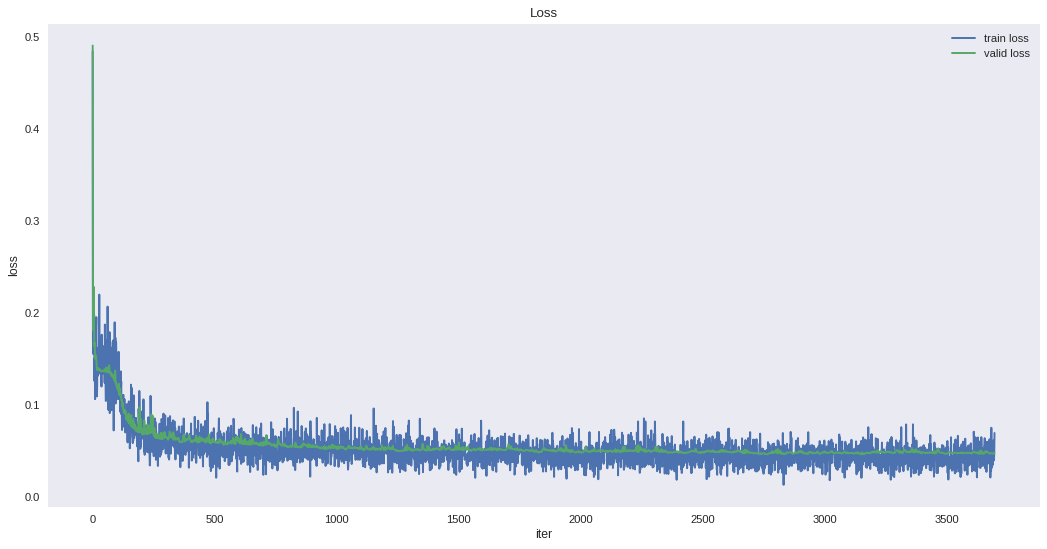

In [38]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

**Plot of ROC AUC vs iteration**

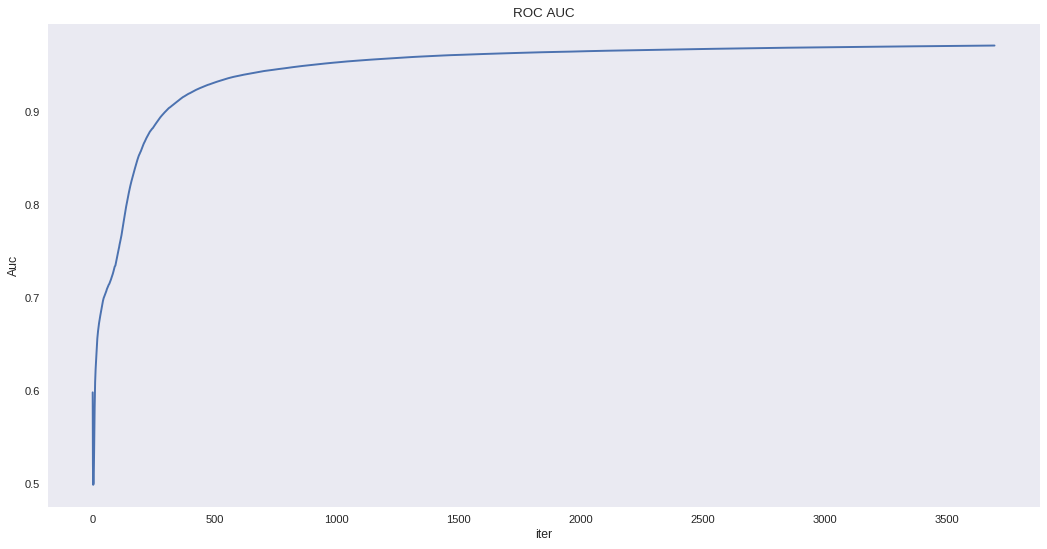

In [39]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_roc)
plt.title("ROC AUC")
plt.xlabel("iter")
plt.ylabel("Auc")
plt.grid()
plt.show()

# Create a submission file

In [0]:
del(comments_train, sentiments_train, seq_length_train, comments_validation, sentiments_validation, seq_length_validation)

**Create predictions matrix in folds and save the predictions in a csv file**

In [41]:
with tf.Session() as sess:  
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = len(test_id)
    k = 40
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        if i != (k-1):
            start = (step*i)
            end = (step*(i+1)) 
        else:
            start = (step*i)
            end = len(test_id)
            
        

        # feed dictionary for the fold
        feed_dict_test =  {X:sequence_generator(comments_test[start:end], max_length, size),
                            length:seq_length_test[start:end],
                            keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = logits.eval(session=sess, feed_dict = feed_dict_test)
        if i == 0:
            preds  = fold_preds
        else:
            preds = np.append(preds, fold_preds, axis=0)
        
        print("Computed predictions for fold",i)
        
    del(model, comments_test, seq_length_test)
    
    submission_matrix = np.append(np.transpose([test_id]), preds, axis=1)
    del(test_id)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    columns = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    submission = pd.DataFrame(submission_matrix, columns= columns)
    del(submission_matrix)
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-3694
Computed predictions for fold 0
Computed predictions for fold 1
Computed predictions for fold 2
Computed predictions for fold 3
Computed predictions for fold 4
Computed predictions for fold 5
Computed predictions for fold 6
Computed predictions for fold 7
Computed predictions for fold 8
Computed predictions for fold 9
Computed predictions for fold 10
Computed predictions for fold 11
Computed predictions for fold 12
Computed predictions for fold 13
Computed predictions for fold 14
Computed predictions for fold 15
Computed predictions for fold 16
Computed predictions for fold 17
Computed predictions for fold 18
Computed predictions for fold 19
Computed predictions for fold 20
Computed predictions for fold 21
Computed predictions for fold 22
Computed predictions for fold 23
Computed predictions for fold 24
Computed predictions for fold 25
Computed predictions for fold 26
Computed predictions for fold 27
Computed predictions for fol

**Save the submission file in google drive**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'submission.csv', 'parents':[{u'id': file_id_data["download_folder2_id"]}]})
uploaded.SetContentFile("submission.csv")
uploaded.Upload()